In [1]:

from importlib import reload
import os
import pandas as pd
from io import StringIO
import itertools
import ipdb
import datetime
from collections import Counter

import h5py
import json
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
print(tf.__version__)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mytf.s3utils as msu
import mytf.utils as mu
import mytf.validation as mv
import mytf.plot as mp

1.14.0


Using TensorFlow backend.


In [2]:
tf.enable_eager_execution()


#### Mess around with the example weights of cross entropy
Borrow some of the mess code from [earlier book](https://github.com/namoopsoo/aviation-pilot-physiology-hmm/blob/master/notes/2020-01-10-confidence--update.md#play-with-sparse_softmax_cross_entropy-a-little-here)

In [9]:
preds = np.array([[ 1.83809385e-01,  1.00108096e-02, -1.75332371e-03,
         1.12673618e-01],
       [ 1.83426142e-01,  9.55305714e-03, -1.38717750e-03,
         1.12821095e-01],
       [ 1.83396950e-01,  9.47616715e-03, -1.38786808e-03,
         1.12689503e-01],])

for preds, ylabels, weights in [[np.array([[0, 0, 0, 0],
                                 [0, 0, 0, 0],
                                 [0, 0, 0, 0],
                                 [0, 0, 0, 0],
                                 [0, 0, 0, 0],]), np.array([0, 0, 0, 0, 0]),
                                None],
                      [np.array([[1, 0, 0, 0],
                                 [1, 0, 0, 0],
                                 [1, 0, 0, 0],
                                 [1, 0, 0, 0],
                                 [1, 0, 0, 0],]), np.array([0, 0, 0, 0, 0]),
                                  None],
                      [np.array([[1, 0, 0, 1],
                                 [1, 0, 0, 1],
                                 [1, 0, 0, 1],
                                 [1, 0, 0, 1],
                                 [1, 0, 0, 1],]), np.array([0, 0, 0, 0, 0]),
                                  None],
                      [np.array([[2, 0, 0, 0],
                                 [2, 0, 0, 0],
                                 [2, 0, 0, 0],
                                 [2, 0, 0, 0],
                                 [2, 0, 0, 0],]), np.array([0, 0, 0, 0, 0]),
                                  None],
                      [np.array([[9, 0, 0, 0],
                                 [9, 0, 0, 0],
                                 [9, 0, 0, 0],
                                 [9, 0, 0, 0],
                                 [9, 0, 0, 0],]), np.array([0, 0, 0, 0, 0]),
                                  None],
                      [np.array([[ 1.83809385e-01,  1.00108096e-02, -1.75332371e-03,
                         1.12673618e-01],
                       [ 1.83426142e-01,  9.55305714e-03, -1.38717750e-03,
                         1.12821095e-01],
                       [ 1.83396950e-01,  9.47616715e-03, -1.38786808e-03,
                         1.12689503e-01],]), np.array([0, 0, 0]),
                                  None],
                      [np.array([[9, 0, 0, 0],
                                 [9, 0, 0, 0],
                                 [9, 0, 0, 0],
                                 [9, 0, 0, 0],
                                 [9, 0, 0, 0],]), np.array([0, 0, 0, 0, 0]),
                                  np.array([1, 1, 1, 1, 1])],
                      [np.array([[9, 0, 0, 0],
                                 [9, 0, 0, 0]]), 
                                 np.array([0, 1]),
                                np.array([1, 0])],
                      [np.array([[9, 0, 0, 0],
                                 [9, 0, 0, 0]]), 
                                 np.array([0, 1]),
                                np.array([0, 1])]
                       
                      ]:
    kwargs = {**{'labels': ylabels.astype('int64'),
                 'logits': preds.astype('float64'),},
             **({'weights': weights} if weights is not None else {})}
    loss = tf.losses.sparse_softmax_cross_entropy(**kwargs).numpy()
    print({'ylabels': ylabels, 'preds': preds, 'weights': weights, 'loss': loss})
    print()

{'ylabels': array([0, 0, 0, 0, 0]), 'preds': array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]]), 'weights': None, 'loss': 1.3862943649291992}

{'ylabels': array([0, 0, 0, 0, 0]), 'preds': array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]]), 'weights': None, 'loss': 0.7436683773994446}

{'ylabels': array([0, 0, 0, 0, 0]), 'preds': array([[1, 0, 0, 1],
       [1, 0, 0, 1],
       [1, 0, 0, 1],
       [1, 0, 0, 1],
       [1, 0, 0, 1]]), 'weights': None, 'loss': 1.0064088106155396}

{'ylabels': array([0, 0, 0, 0, 0]), 'preds': array([[2, 0, 0, 0],
       [2, 0, 0, 0],
       [2, 0, 0, 0],
       [2, 0, 0, 0],
       [2, 0, 0, 0]]), 'weights': None, 'loss': 0.3407529592514038}

{'ylabels': array([0, 0, 0, 0, 0]), 'preds': array([[9, 0, 0, 0],
       [9, 0, 0, 0],
       [9, 0, 0, 0],
       [9, 0, 0, 0],
       [9, 0, 0, 0]]), 'weights': None, 'loss': 0.00037016088026575744}

{'ylab

Ok then I suppose for sake of argument, since the `label=1` loss is the only one getting 
minimized, I want to set that weight to always a low weight and just see what happens...

In [10]:
# Working dir... for new model
save_dir = 'history'
ts = mu.quickts(); print('starting,', ts)

workdir = f'{save_dir}/{ts}'
os.mkdir(workdir)
print(f'Made new workdir, {workdir}')

starting, 2020-01-18T200155Z
Made new workdir, history/2020-01-18T200155Z


In [26]:
lstm_params = [{
    'units': 64,
    'dropout': 0.5,
    'recurrent_dropout': 0.5,
    'batch_input_shape': (None, 64, 8),
    'kernel_initializer': tf.initializers.glorot_normal() # GlorotNormal()
                           #tf.initializers.he_normal()
    },

]

optimizer_params = {
    'learning_rate': 0.001,  
    'beta1': 0.9, 
    'beta2': 0.999, 
    'epsilon': 1e-08
}

def bake_model(lstm_params):

    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(**lstm_params[0]),
        # 4 because 'A', 'B', 'C', 'D'.
        tf.keras.layers.Dense(4)])
    return model

In [27]:

BATCH_SIZE = 32
EPOCHS = 1
# Use datasets from 
# 2019-12-25.ipynb
# 
# train ... new datasets, ...
datadir = 'history/2019-12-22T174803Z'
# train_loc = f'{datadir}/train_balanced.h5'
test_loc = f'{datadir}/test_balanced.h5'
train_shuff_loc = f'{datadir}/train_scaled_balanced_shuffled.h5'
print(mu.h5_keys(train_shuff_loc))
print(mu.h5_keys(test_loc))

X, Ylabels = mu.read_h5_two(
                source_location=train_shuff_loc, 
                Xdataset=f'X',
                Ydataset=f'Ylabels')
size = X.shape[0]

# save base unfitted model.
model = bake_model(lstm_params)
mu.save_model(model=model, 
              loc=f'{workdir}/00000__unfitted_model.h5')



['X', 'Ylabels']
['X_0', 'X_1', 'X_2', 'X_3', 'Ylabels_0', 'Ylabels_1', 'Ylabels_2', 'Ylabels_3']


In [28]:
%%time
modelloc = f'{workdir}/00000__unfitted_model.h5'
print(f'Start train with {modelloc}')
model = mu.load_model(modelloc)

class_weights = {0: 1., 1: 0., 2: 0., 3: 0.}
dataset_batches = mu.build_dataset_weighty_v3(
        {'x_train': X,
         'ylabels_train': Ylabels.astype('int64')},
        list(range(size)), 
        class_weights,
        batch_size=BATCH_SIZE)
    
mu.do_train( 
        model,
        dataset_batches,
        k=size,
        epochs=EPOCHS,
        optimizer_params=optimizer_params,
        saveloc=workdir)

Start train with history/2020-01-18T200155Z/00000__unfitted_model.h5





0it [00:00, ?it/s]


1it [00:00,  1.59it/s]


2it [00:00,  1.82it/s]


3it [00:01,  2.04it/s]


4it [00:01,  2.21it/s]


5it [00:02,  2.35it/s]


6it [00:02,  2.46it/s]


7it [00:02,  2.32it/s]


8it [00:03,  2.44it/s]


9it [00:03,  2.54it/s]


10it [00:03,  2.61it/s]


11it [00:04,  2.66it/s]


12it [00:04,  2.71it/s]


13it [00:05,  2.52it/s]


14it [00:05,  2.61it/s]


15it [00:05,  2.68it/s]


16it [00:06,  2.75it/s]


17it [00:06,  2.80it/s]


18it [00:07,  2.58it/s]


19it [00:07,  2.65it/s]


20it [00:07,  2.71it/s]


21it [00:08,  2.72it/s]


22it [00:08,  2.73it/s]


23it [00:08,  2.73it/s]


24it [00:09,  2.71it/s]


25it [00:09,  2.48it/s]


26it [00:10,  2.58it/s]


27it [00:10,  2.65it/s]


28it [00:10,  2.72it/s]


29it [00:11,  2.76it/s]


30it [00:11,  2.54it/s]


31it [00:11,  2.59it/s]


32it [00:12,  2.63it/s]


33it [00:12,  2.66it/s]


34it [00:13,  2.67it/s]


35it [00:13,  2.69it/s]


36it [00:13,  2.51it/s]


37it [00:14,  2.59it/s]


38it [00:14,  2.65it/s]

230it [01:28,  2.46it/s]


231it [01:29,  2.43it/s]


232it [01:29,  2.44it/s]


233it [01:30,  2.53it/s]


234it [01:30,  2.41it/s]


235it [01:30,  2.49it/s]


236it [01:31,  2.54it/s]


237it [01:31,  2.58it/s]


238it [01:31,  2.60it/s]


239it [01:32,  2.59it/s]


240it [01:32,  2.62it/s]


241it [01:33,  2.44it/s]


242it [01:33,  2.51it/s]


243it [01:33,  2.54it/s]


244it [01:34,  2.56it/s]


245it [01:34,  2.59it/s]


246it [01:35,  2.37it/s]


247it [01:35,  2.44it/s]


248it [01:36,  2.51it/s]


249it [01:36,  2.57it/s]


250it [01:36,  2.63it/s]


251it [01:37,  2.65it/s]


252it [01:37,  2.46it/s]


253it [01:37,  2.50it/s]


254it [01:38,  2.53it/s]


255it [01:38,  2.57it/s]


256it [01:39,  2.55it/s]


257it [01:39,  2.61it/s]


258it [01:39,  2.42it/s]


259it [01:40,  2.48it/s]


260it [01:40,  2.53it/s]


261it [01:41,  2.58it/s]


262it [01:41,  2.62it/s]


263it [01:41,  2.65it/s]


264it [01:42,  2.66it/s]


265it [01:42,  2.44it/s]


266it [01:43,  2.50it/s]


2

457it [02:58,  2.45it/s]


458it [02:59,  2.52it/s]


459it [02:59,  2.56it/s]


460it [02:59,  2.59it/s]


461it [03:00,  2.62it/s]


462it [03:00,  2.41it/s]


463it [03:01,  2.48it/s]


464it [03:01,  2.53it/s]


465it [03:01,  2.58it/s]


466it [03:02,  2.62it/s]


467it [03:02,  2.64it/s]


468it [03:02,  2.45it/s]


469it [03:03,  2.53it/s]


470it [03:03,  2.59it/s]


471it [03:04,  2.60it/s]


472it [03:04,  2.64it/s]


473it [03:04,  2.66it/s]


474it [03:05,  2.45it/s]


475it [03:05,  2.52it/s]


476it [03:06,  2.59it/s]


477it [03:06,  2.65it/s]


478it [03:06,  2.68it/s]


479it [03:07,  2.70it/s]


480it [03:07,  2.71it/s]


481it [03:07,  2.47it/s]


482it [03:08,  2.54it/s]


483it [03:08,  2.61it/s]


484it [03:09,  2.66it/s]


485it [03:09,  2.69it/s]


486it [03:09,  2.73it/s]


487it [03:10,  2.54it/s]


488it [03:10,  2.61it/s]


489it [03:10,  2.65it/s]


490it [03:11,  2.71it/s]


491it [03:11,  2.71it/s]


492it [03:12,  2.73it/s]


493it [03:12,  2.51it/s]


4

684it [04:25,  2.41it/s]


685it [04:26,  2.48it/s]


686it [04:26,  2.51it/s]


687it [04:27,  2.56it/s]


688it [04:27,  2.56it/s]


689it [04:27,  2.50it/s]


690it [04:28,  2.27it/s]


691it [04:28,  2.23it/s]


692it [04:29,  2.23it/s]


693it [04:29,  2.35it/s]


694it [04:30,  2.45it/s]


695it [04:30,  2.55it/s]


696it [04:30,  2.62it/s]


697it [04:31,  2.47it/s]


698it [04:31,  2.55it/s]


699it [04:31,  2.61it/s]


700it [04:32,  2.65it/s]


701it [04:32,  2.66it/s]


702it [04:33,  2.70it/s]


703it [04:33,  2.49it/s]


704it [04:33,  2.54it/s]


705it [04:34,  2.55it/s]


706it [04:34,  2.58it/s]


707it [04:34,  2.62it/s]


708it [04:35,  2.65it/s]


709it [04:35,  2.45it/s]


710it [04:36,  2.53it/s]


711it [04:36,  2.58it/s]


712it [04:36,  2.60it/s]


713it [04:37,  2.62it/s]


714it [04:37,  2.64it/s]


715it [04:38,  2.44it/s]


716it [04:38,  2.51it/s]


717it [04:38,  2.56it/s]


718it [04:39,  2.61it/s]


719it [04:39,  2.66it/s]


720it [04:40,  2.46it/s]


7

911it [05:54,  2.67it/s]


912it [05:54,  2.68it/s]


913it [05:55,  2.49it/s]


914it [05:55,  2.55it/s]


915it [05:55,  2.59it/s]


916it [05:56,  2.64it/s]


917it [05:56,  2.66it/s]


918it [05:57,  2.69it/s]


919it [05:57,  2.45it/s]


920it [05:57,  2.53it/s]


921it [05:58,  2.58it/s]


922it [05:58,  2.61it/s]


923it [05:59,  2.63it/s]


924it [05:59,  2.67it/s]


925it [05:59,  2.44it/s]


926it [06:00,  2.50it/s]


927it [06:00,  2.53it/s]


928it [06:01,  2.58it/s]


929it [06:01,  2.63it/s]


930it [06:01,  2.65it/s]


931it [06:02,  2.42it/s]


932it [06:02,  2.48it/s]


933it [06:02,  2.55it/s]


934it [06:03,  2.63it/s]


935it [06:03,  2.67it/s]


936it [06:04,  2.46it/s]


937it [06:04,  2.54it/s]


938it [06:04,  2.62it/s]


939it [06:05,  2.68it/s]


940it [06:05,  2.69it/s]


941it [06:05,  2.67it/s]


942it [06:06,  2.69it/s]


943it [06:06,  2.49it/s]


944it [06:07,  2.57it/s]


945it [06:07,  2.62it/s]


946it [06:07,  2.66it/s]


947it [06:08,  2.69it/s]


9

CPU times: user 7min 3s, sys: 1.04 s, total: 7min 4s
Wall time: 7min 5s


Text(0.5, 1.0, 'Train xentropy logloss on epoch=0,batch=1090')

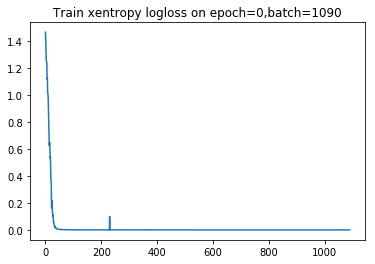

In [29]:
# Look at a most recent train loss plot
historydir = 'history'
with open(f'{workdir}/epoch_000_batch_01090_train_loss_history.json') as fd:
    losshistory = json.load(fd)
    
plt.plot(losshistory) 
plt.title('Train xentropy logloss on epoch=0,batch=1090')

In [33]:
epoch = 0
print(len(list(np.arange(0, 1100, 200))))
for batch in tqdm(list(np.arange(0, 1100, 200))):
    step = batch
    prefix = (f'{workdir}/epoch_{str(epoch).zfill(3)}'
                           f'_batch_{str(batch).zfill(5)}')

    modelname = f'{prefix}_model.h5'
    print(modelname, os.path.exists(modelname))

6


history/2020-01-18T200155Z/epoch_000_batch_00000_model.h5 True
history/2020-01-18T200155Z/epoch_000_batch_00200_model.h5 True
history/2020-01-18T200155Z/epoch_000_batch_00400_model.h5 True
history/2020-01-18T200155Z/epoch_000_batch_00600_model.h5 True
history/2020-01-18T200155Z/epoch_000_batch_00800_model.h5 True
history/2020-01-18T200155Z/epoch_000_batch_01000_model.h5 True



starting validation 2020-01-18T204828Z


history/2020-01-18T200155Z/epoch_000_batch_00000_model.h5 True
history/2020-01-18T200155Z/epoch_000_batch_00200_model.h5 True
history/2020-01-18T200155Z/epoch_000_batch_00400_model.h5 True
history/2020-01-18T200155Z/epoch_000_batch_00600_model.h5 True
history/2020-01-18T200155Z/epoch_000_batch_00800_model.h5 True
history/2020-01-18T200155Z/epoch_000_batch_01000_model.h5 True

done validation 2020-01-18T212308Z


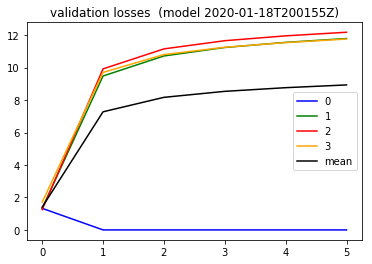

In [34]:
print('starting validation', mu.quickts())
batch_losses_vec = []

epoch = 0
for batch in tqdm(list(np.arange(0, 1100, 200))):
    step = batch
    prefix = (f'{workdir}/epoch_{str(epoch).zfill(3)}'
                           f'_batch_{str(batch).zfill(5)}')

    modelname = f'{prefix}_model.h5'
    print(modelname, os.path.exists(modelname))

    steploss = mv.perf_wrapper(modelname,
                               dataloc=test_loc,
                               eager=True,
                              batch_size=32)
    batch_losses_vec.append([float(x) for x in steploss])
    mv.json_save({'batch_losses_vec': batch_losses_vec,
                  'step': int(step)
              }, 
              f'{prefix}_validation_losses.json')
    
print('done validation', mu.quickts())
#####
lossesarr = np.array(batch_losses_vec)
meanlossesarr = np.mean(lossesarr, axis=1)

batch_losses_vec[:5]
#batch_losses_vec = []
#for step in np.arange(0, 1068, 10):
# [2.8359528, 0.45356295, 1.7049086, 4.099845]

plt.plot([x[0] for x in batch_losses_vec], color='blue', label='0')
plt.plot([x[1] for x in batch_losses_vec], color='green', label='1')
plt.plot([x[2] for x in batch_losses_vec], color='red', label='2')
plt.plot([x[3] for x in batch_losses_vec], color='orange', label='3')
plt.plot(meanlossesarr, color='black', label='mean')
plt.title(f'validation losses  (model {ts})')
plt.legend()     
        

Nice ok so as hoped, I can control label=0 to be learned instead.

Next what if I can dynamically control this. So, for each batch, 
use the batch losses to calibrate the weights for the next batch somehow.